## Exercise 10 Model-based RL with MPPI

In this exercise, you will first learn a dynamics model and reward model and combine it with an MPPI controller.

MPPI was very successfully combined with Deep Learning in the paper [Temporal Difference Learning for Model Predictive Control](https://nicklashansen.github.io/td-mpc/), allowing to do control on even very high dimensional action spaces. **Take a look!**
A lot of RL practitioners are using sampled based methods like MPPI, as they not require any first order or even second order derivatives. Thus, in the end you only need to learn a transition model.


### 1. Collect data to learn a dynamics and reward model

In the following, we collect data to learn a dynamics and reward model. For this we use a random policy that interacts with the environment.

In [1]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

GYM_ENV = "Pendulum-v1"


# Define the Gym environment (Pendulum-v1 in this case)
env = gymnasium.make(GYM_ENV, max_episode_steps=100)

# Set the random seed for reproducibility
seed = 41
np.random.seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)  # this is often forgotten ;)

# Function to collect data from the environment using a random policy
def collect_data(env, num_episodes):
    states = []
    next_states = []
    actions = []
    rewards = []

    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()

        terminated = False
        while True:
            # Random policy: Choose a random action within the action space
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, _ = env.step(action)

            states.append(state)
            next_states.append(next_state)
            actions.append(action)
            rewards.append(reward)

            state = next_state

            if terminated or truncated:
                break

    # convert data
    states = np.array(states, dtype=np.float32)
    next_states = np.array(next_states, dtype=np.float32)
    actions = np.array(actions, dtype=np.float32)
    rewards = np.array(rewards, dtype=np.float32)

    return states, actions, rewards, next_states


# Collect data from the environment
num_episodes = 2000  # You can adjust this to collect more or fewer episodes
states, actions, rewards, next_states = collect_data(env, num_episodes)


# Print some statistics about the collected data
print(f"\nNum samples: \t{len(states)}")
print(f"Avg reward: \t{np.mean(rewards):.2f}")
print(f"Min reward: \t{np.min(rewards):.2f}")
print(f"Max reward: \t{np.max(rewards):.2f}")

# Close the Gym environment
env.close()

100%|██████████| 2000/2000 [00:08<00:00, 237.24it/s]



Num samples: 	200000
Avg reward: 	-6.19
Min reward: 	-16.27
Max reward: 	-0.00


### 2. Train a reward and dynamics model

Given the dataset we now train a model for the reward and the dynamics, which allows us later to efficiently generate rollout trajectories for the MPPI algorithm.

In [2]:
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# define supervised learning parameters 
HIDDEN_DIM = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
BATCH_SIZE = 64
SPLIT_RATIO = 0.8
STATE_DIM = states.shape[1]
ACTION_DIM = actions.shape[1]

# convert to tensors
states_ = torch.from_numpy(states)
actions_ = torch.from_numpy(actions)
rewards_ = torch.from_numpy(rewards)
next_states_ = torch.from_numpy(next_states)


# split data into training and validation sets
split_ratio = 0.8
split_idx = int(len(states_) * split_ratio)
train_states, val_states = states_[:split_idx], states_[split_idx:]
train_actions, val_actions = actions_[:split_idx], actions_[split_idx:]
train_rewards, val_rewards = rewards_[:split_idx], rewards_[split_idx:]
train_next_states, val_next_states = next_states_[:split_idx], next_states_[split_idx:]


# create dataloaders
train_dataset = TensorDataset(train_states, train_actions, train_rewards, train_next_states)
val_dataset = TensorDataset(val_states, val_actions, val_rewards, val_next_states)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE)


# define a simple neural network structure
class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        next_state = self.fc(x)
        return next_state

# initialize networks and optimizers
model_dyn = MLP(STATE_DIM, ACTION_DIM, HIDDEN_DIM, STATE_DIM)
model_rew = MLP(STATE_DIM, ACTION_DIM, HIDDEN_DIM, 1)
optimizer = optim.Adam([*model_rew.parameters(), *model_dyn.parameters()], lr=LEARNING_RATE)
criterion = nn.MSELoss()

# training loop for the models
stats = defaultdict(list)
for epoch in tqdm(range(NUM_EPOCHS)):
    # start the new stats for each epoch
    for field in ["train_loss_dyn", "train_loss_rew", "val_loss_dyn", "val_loss_rew"]:
        stats[field].append(0)

    # training
    for bidx, batch in enumerate(train_loader):
        batch_state, ba, br, bns = batch
        
        # dynamics model loss
        pred_bns = model_dyn(batch_state, ba)
        loss_dyn = criterion(pred_bns, bns)

        # reward model loss
        pred_br = model_rew(batch_state, ba)[:, 0]
        loss_rew = criterion(pred_br, br)

        # train models
        # TODO: Update both models with the optimizer.
        #       Hint: You can add up the losses!
        optimizer.zero_grad()
        (loss_dyn + loss_rew).backward()
        optimizer.step()

        # logging with running average
        stats["train_loss_dyn"][-1] = (bidx * stats["train_loss_dyn"][-1] + loss_dyn.item()) / (bidx + 1)
        stats["train_loss_rew"][-1] = (bidx * stats["train_loss_rew"][-1] + loss_rew.item()) / (bidx + 1)

    # validation
    for bidx, batch in enumerate(val_loader):
        batch_state, ba, br, bns = batch

        with torch.no_grad():
            # dynamics model loss
            pred_bns = model_dyn(batch_state, ba)
            loss_dyn = criterion(pred_bns, bns)

            # reward model loss
            pred_br = model_rew(batch_state, ba)[:, 0]
            loss_rew = criterion(pred_br, br)

        # logging with running average
        stats["val_loss_dyn"][-1] = (bidx * stats["val_loss_dyn"][-1] + loss_dyn.item()) / (bidx + 1)
        stats["val_loss_rew"][-1] = (bidx * stats["val_loss_rew"][-1] + loss_rew.item()) / (bidx + 1)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


By comparing the loss on the validation data set with the loss on the training data set, how well the models fit the data.

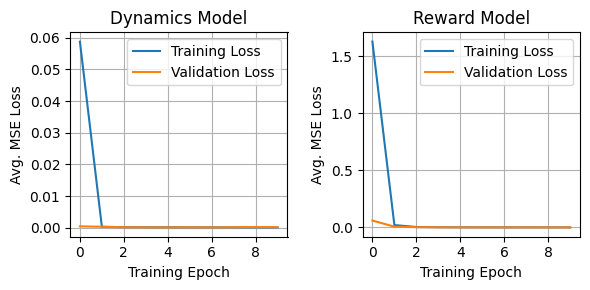

In [3]:
# plotting training and validation losses
plt.figure(figsize=(6, 3))

# training and validation loss for dynamics model
plt.subplot(1, 2, 1)
plt.plot(stats["train_loss_dyn"], label="Training Loss")
plt.plot(stats["val_loss_dyn"], label="Validation Loss")
plt.title("Dynamics Model")
plt.xlabel("Training Epoch")
plt.ylabel("Avg. MSE Loss")
plt.grid()
plt.legend()

# training and validation loss for reward model
plt.subplot(1, 2, 2)
plt.plot(stats["train_loss_rew"], label="Training Loss")
plt.plot(stats["val_loss_rew"], label="Validation Loss")
plt.title("Reward Model")
plt.xlabel("Training Epoch")
plt.ylabel("Avg. MSE Loss")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

If you did everything correctly, the training and validation loss should be quite small and almost the same.

### 3. The MPPI Controller

We finally can define the MPPI controller by implementing the algorithm of the lecture:



In [23]:
# initialize the gym environment
env = gymnasium.make(GYM_ENV, max_episode_steps=200, render_mode="rgb_array")

I = 30                # number of rollouts in each iteration
N = 40                 # planning horizon
LAMBDA = 4.          # regularization parameter
SIGMA = 0.5            # sigma



class MPPIController:
    def __init__(self, env, model_dyn, model_rew):
        self.action_dim = env.action_space.low.ndim
        self.action_min = torch.tensor(env.action_space.low)
        self.action_max = torch.tensor(env.action_space.high)

        self.env = env
        self.model_dyn = model_dyn
        self.model_rew = model_rew
        self.previous_as = torch.zeros(N, self.action_dim)

    def reset(self):
        self.previous_as = torch.zeros(N, self.action_dim)

    def rollout(self, state: torch.Tensor):
        """Parallelized rollout by adding noise around the previously planned actions.

        Note, that the sampling is slightly different to adjust to RL environments.
        Here we leave out the correction term for the importance sampling.
        """

        batch_state = state.repeat((I, 1))

        normal_mu = torch.zeros((I, N, self.action_dim))
        sigma = torch.full_like(normal_mu, SIGMA)

        batch_noise = torch.normal(normal_mu, sigma)
        ba_rollout = self.previous_as[None, ...] + batch_noise
        ba_rollout = torch.clip(ba_rollout, self.action_min, self.action_max)
        batch_state_rollout = []
        batch_reward_rollout = []

        for idx in range(N):
            with torch.no_grad():
                br = self.model_rew(batch_state, ba_rollout[:, idx])
                bns = self.model_dyn(batch_state, ba_rollout[:, idx])

            batch_state_rollout.append(batch_state)
            batch_reward_rollout.append(br[..., 0])

            batch_state = bns

        batch_state_rollout = torch.stack(batch_state_rollout, dim=0)
        batch_reward_rollout = torch.stack(batch_reward_rollout, dim=0)
        # add the correction term
        correction = torch.einsum("ND,IND->IN", self.previous_as, batch_noise).T
        batch_reward_rollout += LAMBDA * correction / SIGMA

        return batch_state_rollout, ba_rollout, batch_reward_rollout

    def weighted_averaging(self, batch_action_rollout, batch_reward_rollout):
        si = batch_reward_rollout.sum(dim=0)

        # TODO: Calculate the weighting of the trajectories.
        #       Hint 1: The softmax can be numerically unstable... thus it is best if you subtract the return.
        #       Hint 2: The relevant lines in the algorithm are from line 13 to 17 on slide 26.
        #       Hint 3: Different to the slides, we are using rewards here instead of costs!
        beta = si.max(dim=0)[0]
        wi = torch.exp((si - beta) / LAMBDA)
        # normalize wi by eta
        eta = torch.sum(wi)
        wi = wi / eta

        return torch.einsum("nhd,n->hd", batch_action_rollout, wi)
    
    def __call__(self, state):
        # handle standard states that are not a tensor
        if isinstance(state, np.ndarray):
            state = torch.from_numpy(state)
        if state.ndim == 1:
            state = state[None, :]

        _, batch_action_rollout, batch_reward_rollout = self.rollout(state)

        # shift for warmstart
        comb_as = self.weighted_averaging(batch_action_rollout, batch_reward_rollout)
        self.previous_as[: -1] = comb_as[1: ]

        return comb_as[0]


mppi = MPPIController(env, model_dyn, model_rew)

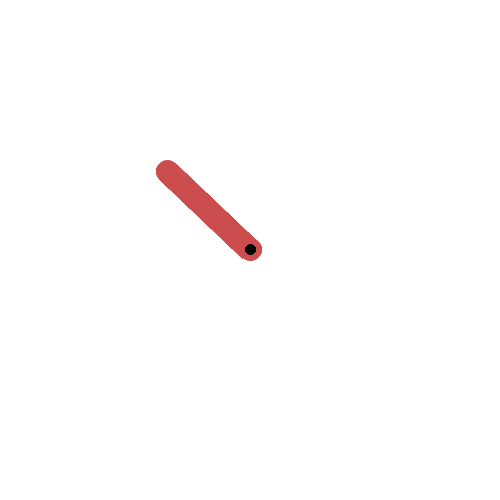

In [24]:
from visualization import save_rgb_animation
from IPython.display import Image as IImage


def rendered_rollout(policy, env, max_steps=500):
    steps = 0
    
    state, _ = env.reset()
    imgs = [env.render()]

    while steps < max_steps:
        action = policy(state).numpy()
        state, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
 
        steps += 1

        if terminated or truncated:
            break
    
    return imgs

env.reset()
mppi = MPPIController(env, model_dyn, model_rew)
imgs = rendered_rollout(mppi, env)
save_rgb_animation(imgs, f"{env.spec.id}.gif", duration=40)
IImage(filename=f"{env.spec.id}.gif")

**Optional**: What are the most "extreme" parameters such that MPPI still works?